In [167]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV


from sklearn.metrics import ConfusionMatrixDisplay , roc_auc_score 
from sklearn.metrics import RocCurveDisplay


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import warnings
warnings.filterwarnings('ignore')


In [168]:
dow_categories = ['Monday' , 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday' , 'Saturday' , 'Sunday']

def is_fatal(details):

    fatal_keywords = [
    'died', 'killed', 'fatal', 'dead', 'mauled to death', 'succumbed',
    'did not survive', 'passed away', 'pronounced dead', 'lost his life',
    'lost her life', 'slain', 'fatally injured', 'mortally wounded'
    ]
    return any(keyword in details.lower() for keyword in fatal_keywords)


def convert_age(age):
    if pd.isna(age) or age == '':  # Handle NaN
        return math.nan
    if isinstance(age, str):
        age = age.strip()  # Remove leading/trailing whitespace
        # Handle months
        if 'months' in age:
            months = int(age.split()[0])
            return months / 12
            
        # Remove non-numeric characters like quotes, and try converting to float
        age = ''.join(filter(str.isdigit, age))
        if age:
            return float(age)
    return age # If it's already a number, return it as is




In [169]:
df = pd.read_csv("bear_attacks.csv" )
df['Date'] = pd.to_datetime(df.Date , format = 'mixed' , errors='coerce')
df['year'] = pd.Categorical(df.Date.dt.year.astype('Int64') , ordered=True)
df['month'] = pd.Categorical(df.Date.dt.month.astype('Int64') ,categories = list(range(1 , 13)) )
df['day_of_month'] = pd.Categorical(df.Date.dt.day.astype('Int64') ,categories = list(range(1 , 32)) )
df['day_of_week'] = pd.Categorical(df.Date.dt.day_name() , categories = dow_categories)
df['Fatal'] = df['Details'].apply(is_fatal).astype(int)
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=dow_categories, ordered=True)
df['Gender'] = pd.Categorical(df['Gender'])
df['Age'] = df['Age'].apply(convert_age)
df.loc[df['Age'] == "" , 'Age'] = np.nan

df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,year,month,day_of_month,day_of_week,Fatal
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33.0,male,2018,8,23,Thursday,1
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31.0,male,2018,7,3,Tuesday,1
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64.0,female,1999,7,9,Friday,0
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28.0,male,1990,12,8,Saturday,1
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46.0,male,1983,11,29,Tuesday,0


In [170]:
contingency_table = pd.crosstab(df['Bear'], df['Fatal'])


conditional_probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

round(conditional_probabilities, 2)

Fatal,0,1
Bear,,
Black,0.23,0.77
Brown,0.24,0.76
Polar,0.29,0.71


In [171]:
contingency_table = pd.crosstab(df['Gender'], df['Fatal'])


conditional_probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

round(conditional_probabilities, 2)

Fatal,0,1
Gender,,
female,0.15,0.85
male,0.27,0.73


In [172]:
contingency_table = pd.crosstab(index = [df['month'] , df['Bear']], columns = df['Fatal'])


conditional_probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

round(conditional_probabilities, 2)

Fatal           0     1
month Bear             
1     Brown  0.00  1.00
      Polar  0.00  1.00
2     Brown  0.00  1.00
4     Black  0.00  1.00
      Brown  1.00  0.00
5     Black  0.13  0.87
      Brown  0.50  0.50
6     Black  0.20  0.80
      Brown  0.18  0.82
7     Black  0.33  0.67
      Brown  0.07  0.93
      Polar  0.50  0.50
8     Black  0.08  0.92
      Brown  0.33  0.67
      Polar  0.00  1.00
9     Black  0.56  0.44
      Brown  0.36  0.64
10    Black  0.67  0.33
      Brown  0.24  0.76
11    Black  0.00  1.00
      Brown  0.00  1.00
      Polar  0.50  0.50
12    Black  0.00  1.00
      Brown  0.00  1.00
      Polar  0.00  1.00

In [173]:
contingency_table = pd.crosstab(index = [df['day_of_week'], df['Bear']] , columns = df['Fatal'])


conditional_probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

round(conditional_probabilities, 2)

Fatal                 0     1
day_of_week Bear             
Monday      Black  0.00  1.00
            Brown  0.21  0.79
Tuesday     Black  0.25  0.75
            Brown  0.40  0.60
            Polar  0.50  0.50
Wednesday   Black  0.12  0.88
            Brown  0.00  1.00
Thursday    Black  0.12  0.88
            Brown  0.30  0.70
            Polar  0.00  1.00
Friday      Black  0.42  0.58
            Brown  0.07  0.93
            Polar  1.00  0.00
Saturday    Black  0.14  0.86
            Brown  0.36  0.64
            Polar  0.00  1.00
Sunday      Black  0.28  0.72
            Brown  0.29  0.71
            Polar  0.00  1.00

In [174]:
contingency_table = pd.crosstab(index = [df['day_of_week'],df['month'] ,df['Bear']] , columns = df['Fatal'])


conditional_probabilities = contingency_table.div(contingency_table.sum(axis=1), axis=0)

round(conditional_probabilities, 2)

Fatal                      0    1
day_of_week month Bear           
Monday      1     Brown  0.0  1.0
            6     Black  0.0  1.0
                  Brown  0.0  1.0
            7     Black  0.0  1.0
                  Brown  0.0  1.0
...                      ...  ...
Sunday      11    Brown  0.0  1.0
                  Polar  0.0  1.0
            5     Black  0.0  1.0
                  Brown  1.0  0.0
            2     Brown  0.0  1.0

[81 rows x 2 columns]

In [175]:
random_state = 42
df2 = df[['Fatal' , 'day_of_week' , 'month' , 'Bear']]
df2 = df2.dropna()
X = df2[['day_of_week' , 'month' , 'Bear']]
X = pd.get_dummies(X)
y = df2['Fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y )


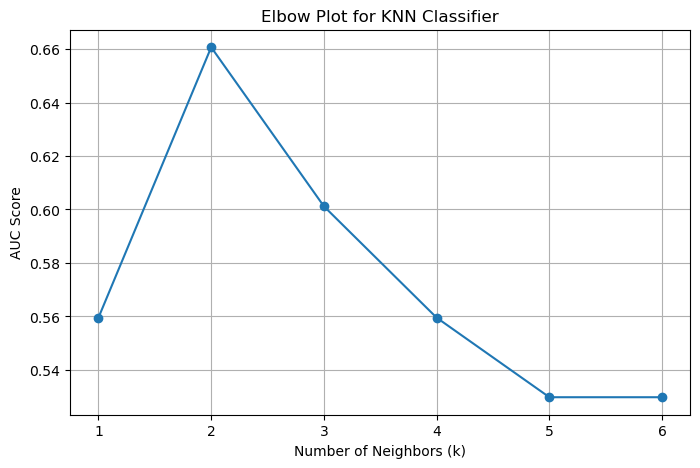

In [176]:
k_values = range(1, 7)  # Test k values from 1 to 20
accuracies = []

# Step 4: Train KNN with different k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(roc_auc_score(y_test, y_pred))

# Step 5: Plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('Elbow Plot for KNN Classifier')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('AUC Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

KNN auc: 0.84


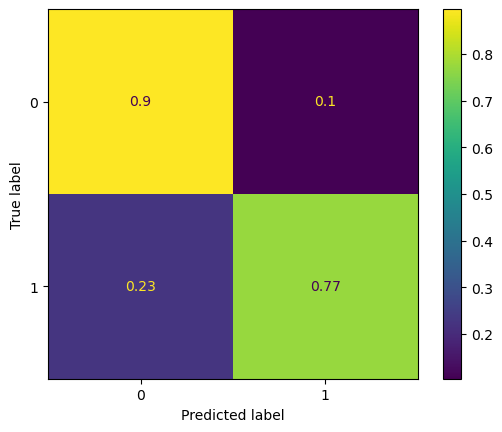

In [177]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train , np.ravel(y_train))

y_pred_knn = knn.predict(X_train)
print(f"KNN auc: {roc_auc_score(y_train  , y_pred_knn):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train , y_pred_knn , normalize='true' )
plt.show()

Fitting 5 folds for each of 708 candidates, totalling 3540 fits
Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Logit auc: 0.50


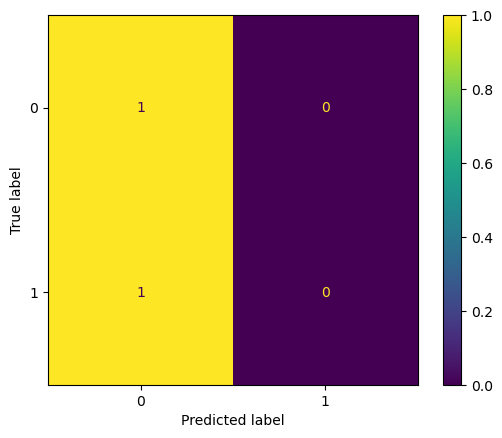

In [178]:
log_reg = LogisticRegression(max_iter=1000)

# Step 4: Define the parameter grid for grid search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.arange(0.001, 0.1 , 0.001)},
    {'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'], 'C': np.arange(0.001, 0.1 , 0.001)},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.2, 0.5, 0.8]}
]

# Step 5: Perform grid search
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring=roc_auc_score, n_jobs=-1, verbose=1)
grid_search.fit(X_train, np.ravel(y_train))

# Step 6: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_logit = best_model.predict(X_train)

# Step 7: Output results
print("Best Parameters:", grid_search.best_params_)
print(f"Logit auc: {roc_auc_score(y_train  , y_pred_logit):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_logit ,   normalize='true' )
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree auc: 0.83


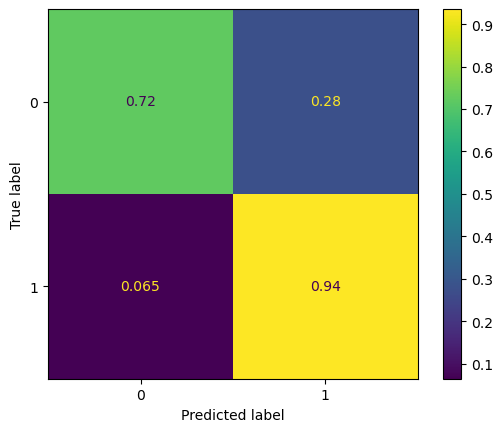

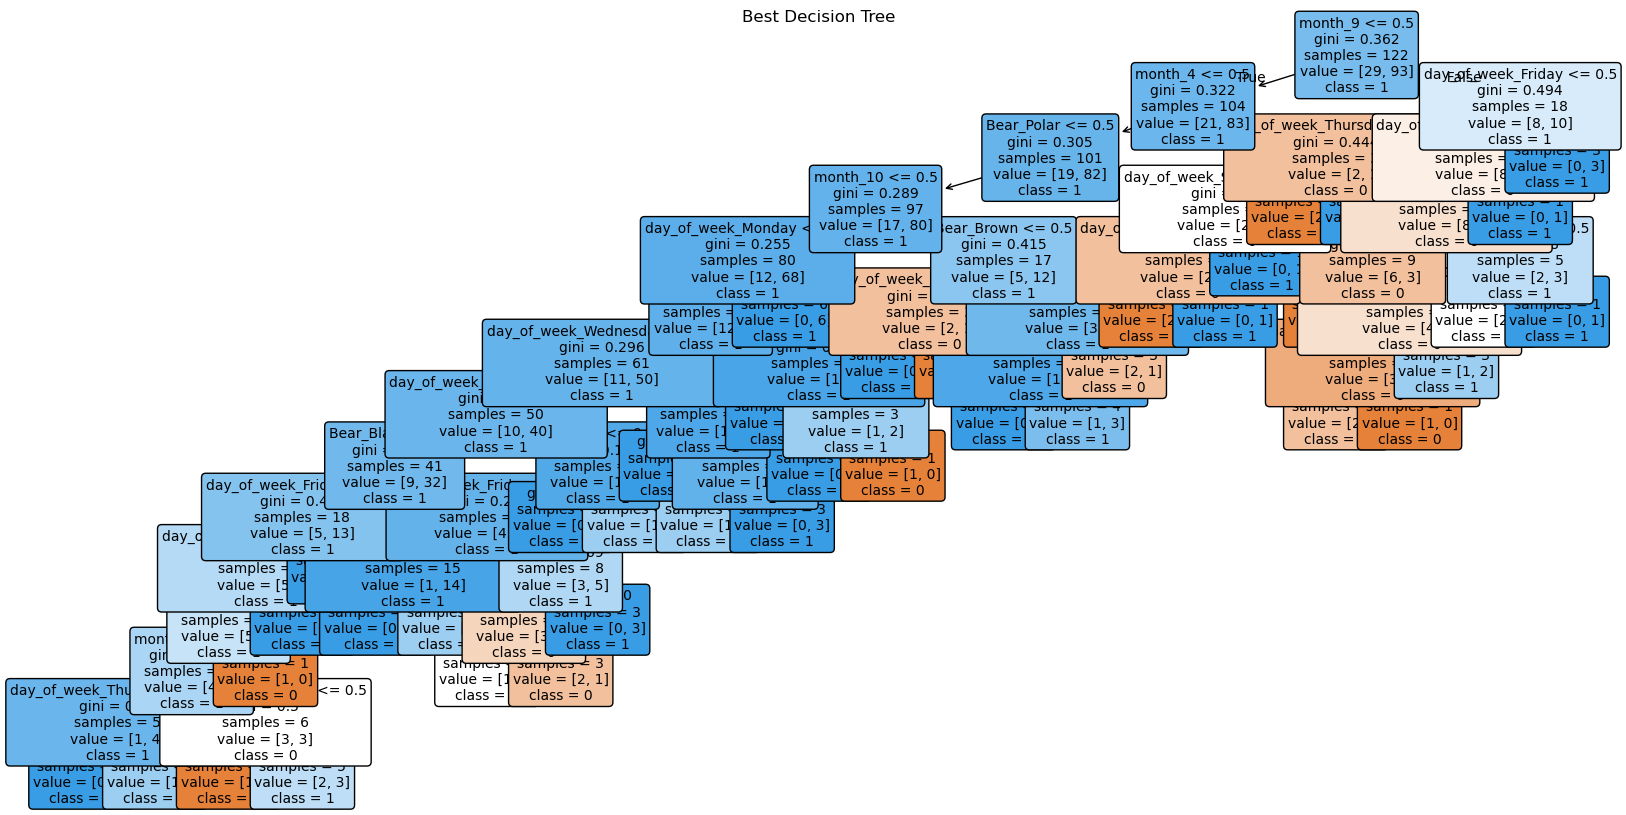

In [179]:
tree = DecisionTreeClassifier(random_state=random_state)

# Step 4: Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criteria
    'max_depth': [None, 5, 10, 15],   # Depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],    # Minimum samples required at a leaf node
    'ccp_alpha': [0.0, 0.01, 0.1]     # Pruning via cost-complexity
}

# Step 5: Perform grid search
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring=roc_auc_score, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_dt = best_model.predict(X_train)

# Step 7: Output results
print("Best Parameters:", grid_search.best_params_)
print(f"Decision Tree auc: {roc_auc_score(y_train  , y_pred_dt):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_dt ,   normalize='true' )
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X_train.columns,  # Use transformed feature names
    class_names=[str(cls) for cls in set(y_train)],  # Convert classes to strings
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Best Decision Tree")
plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.50


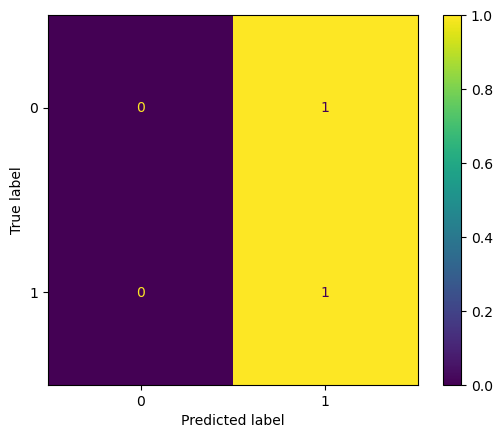

In [180]:
svm = SVC(random_state=random_state)

# Step 4: Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'], # Kernel types
    'gamma': ['scale', 'auto'],          # Kernel coefficient (for non-linear kernels)
    'degree': [2, 3, 4]                  # Degree of the polynomial kernel (only for 'poly')
}

# Step 5: Perform grid search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring=roc_auc_score, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 6: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_svc = best_model.predict(X_train)

# Step 7: Output results
print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy: {roc_auc_score(y_train, y_pred_svc):.2f}")
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_svc , normalize='true' )
plt.show()

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
AUC score: 0.9710317460317461


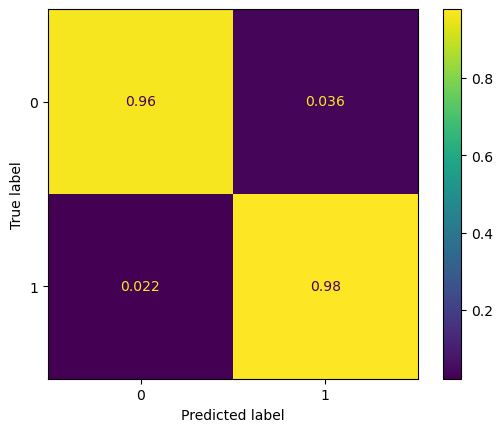

In [181]:


random_state = 42
df = df[['day_of_week' , 'month' , 'Bear' , 'Latitude', 'Longitude' , 'Age' , 'Fatal']]
df = df.dropna()
X = df[['day_of_week' , 'month' , 'Bear' , 'Latitude', 'Longitude' , 'Age' ]]
y = df['Fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state , stratify=y )


categorical_features = ['day_of_week' , 'month' , 'Bear']
numerical_features = ['Latitude', 'Longitude' , 'Age']

# Step 4: Define preprocessors
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = StandardScaler()

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features)#,
        #('cat', categorical_preprocessor, categorical_features)
    ]
)

# Step 5: Create a pipeline with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=random_state))
])

# Step 6: Define a parameter grid for grid search
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],       
    'classifier__max_depth': [None, 3, 5, 10, 20],        
    'classifier__min_samples_split': [2, 5, 10],       
    'classifier__min_samples_leaf': [1, 2, 5],         
    'classifier__ccp_alpha': [0.0, 0.01, 0.1]          
}

# Step 7: Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=roc_auc_score, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

# Output results
print("Best Parameters:", grid_search.best_params_)
print("AUC score:", roc_auc_score(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred , normalize='true' )
plt.show()